In this notebook we evaluate the fitted OCV results

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import autograd
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
from diffthermo.utils import _convert_JMCA_Tdsdx_data_to_dsdx
from diffthermo.utils_PDOS import read_OCV_data, _get_phase_boundaries
from diffthermo.energy import _H_vib_PDOS_quaderature_model, _S_vib_PDOS_quaderature_model, _PDOS_evaluator, calculate_S_config_total, calculate_S_vib_total_PDOS, solve_Theta_max
from diffthermo.energy import GibbsFE_PDOS as GibbsFE

Import data and parameter settings

In [2]:
# read-in Cp data
# read cp experimental data of LiC6
df = pd.read_csv("cp_LiC6.csv",header=None) # deleted those datapoints within miscibility gaps
data = df.to_numpy()
T_measured_LiC6 = data[:,0] 
Cp_measured_LiC6 = data[:,1]/7
# read cp experimental data of C6
df = pd.read_csv("Cp_C6.csv",header=None) # deleted those datapoints within miscibility gaps
data = df.to_numpy()
T_measured_C6 = data[:,0] 
Cp_measured_C6 = data[:,1] * 4.184/(1/(12*6))/6   # convert cal/(g.K) to J/(mol.K)

# convert data
Ts_measured_C6 = torch.from_numpy(T_measured_C6)
Cps_measured_C6 = torch.from_numpy(Cp_measured_C6)
Ts_measured_LiC6 = torch.from_numpy(T_measured_LiC6)
Cps_measured_LiC6 = torch.from_numpy(Cp_measured_LiC6)

# global settings
quaderature_points = 20
style = "Legendre"


Import experimental measured PDOS of C6

In [3]:
# read PDOS experimental data of C6
df = pd.read_csv("PDOS_C6.csv",header=None) 
data = df.to_numpy()
Theta_experiment = data[:,0]/0.0257*300
PDOS_density = data[:,1]


Import experimental measured dsdx data of LixC6 vs x

In [4]:
x_measured_dsdx, dsdx_measured = _convert_JMCA_Tdsdx_data_to_dsdx(datafile_name="TdS_dx_lithiation_320K.csv", T=320)

Import experimental measured OCV data of LixC6 vs x

In [5]:
x1, mu1 = read_OCV_data('47C_lithiation.csv')
T1 = 320
x2, mu2 = read_OCV_data('25C_lithiation.csv')
T2 = 273+25
x3, mu3 = read_OCV_data('57C_lithiation.csv')
T3 = 273+57
x4, mu4 = read_OCV_data('10C_lithiation.csv')
T4 = 273+10

Import fitted PDOS params of fitted LixHM

In [6]:
# Epoch 2884  Loss 0.2231  OCV1 0.0223  OCV2 0.0184  OCV3 0.0330  loss_entropy 125.6291 (dSdx_col 120.1054) Cp_HM 12.1219 Cp_LiHM 11.6010 PD 0.0000    
# Omega0 -3466.6855 Omega1 7414.4780 Omega2 4328.5479 Omega3 -4680.6987 Omega4 -6743.4790 Omega5 -3946.8042 G0 1663.8445 
# omega0 -0.56373113 omega1 0.19531932 omega2 0.40005654 omega3 -0.12321223 omega4 -0.55982774 omega5 0.00079821 omega6 -0.13891523 omega7 -0.18185402 omega8 -0.16848527 omega9 -0.04778971 omega10 -0.09443944 
# g00 1.05817294 g01 0.35428974 
# g10 -0.97393298 g11 -0.69093841
# g20 0.07089702 g21 0.06956254 
# g30 1.01894021 g31 0.11906901        

# initialize g_i_list 
g_ij_list_LixHM = [[ 1.05817294 , 0.35428974 ],
                   [ -0.97393298 , -0.69093841],
                   [ 0.07089702 , 0.06956254 ],
                   [ 1.01894021 , 0.11906901  ]]


Import Hmix parameters (Omegas and G0)

In [7]:
Omega_G0_list = [-3466.6855 , 7414.4780 , 4328.5479 , -4680.6987 , -6743.4790 , -3946.8042 , 1663.8445]

Import Smix parameters (omegas)

In [8]:
S_config_params_list  = [-0.56373113 , 0.19531932 , 0.40005654 , -0.12321223 , -0.55982774 , 0.00079821 , -0.13891523 , -0.18185402 , -0.16848527 , -0.04778971 , -0.09443944  ]

Import fitted PDOS params for Li, HM and LiHM

In [9]:
n_list = [9999.9, 6.0, 1.0]
g_i_list_Li = [2.20836568 , 0.58406430 , 1.28776312 , -0.53589582 ] # pretrained via fit_pure_substance_Cp
g_i_list_HM = [ 0.91502953 , -0.89132202 , 0.06308235 , 0.92034441 ] # pretrained via fit_pure_substance_Cp
g_i_list_LiHM = [ 1.03142691 , -0.54386890 , 0.02469020 , 1.19035435] # pretrained via fit_pure_substance_Cp

# convert pretrained value into torch.tensor
g_i_list_Li = torch.tensor(g_i_list_Li) 
g_i_list_HM = torch.tensor(g_i_list_HM)
g_i_list_LiHM = torch.tensor(g_i_list_LiHM) 
Theta_max_Li = solve_Theta_max(g_i_list = g_i_list_Li, is_x_dependent = False, style = style)
Theta_max_Li = Theta_max_Li.detach()
Theta_max_HM = solve_Theta_max(g_i_list = g_i_list_HM, is_x_dependent = False, style = style)
Theta_max_HM = Theta_max_HM.detach()
Theta_max_LiHM = solve_Theta_max(g_i_list = g_i_list_LiHM, is_x_dependent = False, style = style)
Theta_max_LiHM = Theta_max_LiHM.detach()

In [10]:
## define a total params list for GibbsFE function as input
total_params_list = [Omega_G0_list, S_config_params_list, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_HM, Theta_max_Li]

## Visulize fitted PDOS

First visualize the fitted PDOS of C6 and compare it with experimental measured PDOS of C6

Text(0, 0.5, 'PDOS')

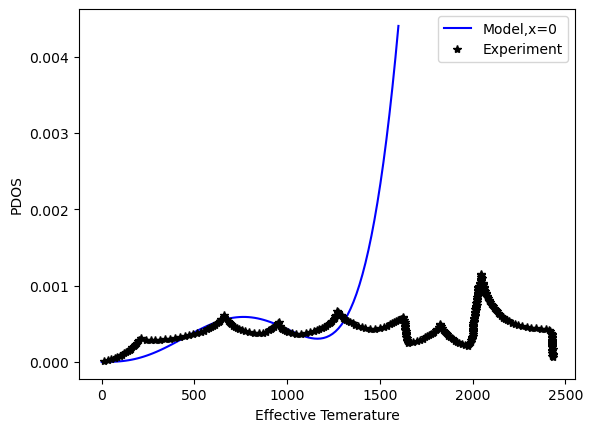

In [11]:
## make sure PDOS is positive everywhere
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
Theta_list = torch.from_numpy(np.linspace(0,Theta_max.detach().numpy()[0],100).astype("float32"))
g_omega_list = torch.zeros(len(Theta_list))
for i in range(0, len(Theta_list)):
    Theta_now = Theta_list[i]
    g_omega_now = _PDOS_evaluator(Theta_now, g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
    g_omega_list[i] = 10**-2 * (Theta_now/Theta_max)**2 *g_omega_now

g_omega_list = g_omega_list.detach().numpy()
Theta_list = Theta_list.numpy()
integral = np.trapz(g_omega_list, Theta_list) 
g_omega_list = g_omega_list/integral
plt.plot(Theta_list, g_omega_list, "b-", label='Model,x=0')
integral = np.trapz(PDOS_density, Theta_experiment) 
PDOS_density = PDOS_density/integral
plt.plot(Theta_experiment, PDOS_density, "k*", label='Experiment')
plt.legend()
plt.xlabel("Effective Temerature")
plt.ylabel("PDOS")


Then visualize modeled PDOS of LiC6. Unfortunately there is no measured PDOS of LiC6

Text(0, 0.5, 'PDOS')

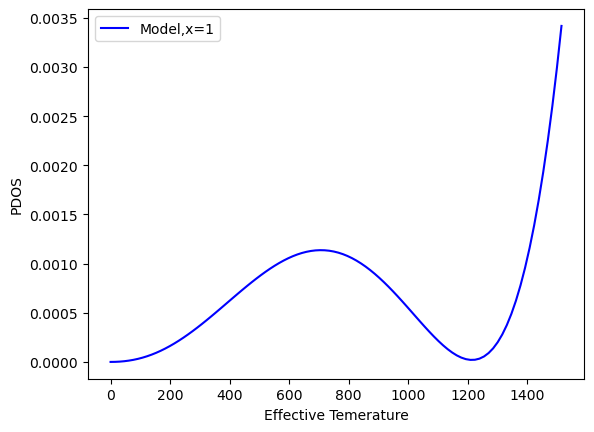

In [12]:
## make sure PDOS is positive everywhere
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
Theta_list = torch.from_numpy(np.linspace(0,Theta_max.detach().numpy()[0],100).astype("float32"))
g_omega_list = torch.zeros(len(Theta_list))
for i in range(0, len(Theta_list)):
    Theta_now = Theta_list[i]
    g_omega_now = _PDOS_evaluator(Theta_now, g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
    g_omega_list[i] = 10**-2 * (Theta_now/Theta_max)**2 *g_omega_now

g_omega_list = g_omega_list.detach().numpy()
Theta_list = Theta_list.numpy()
integral = np.trapz(g_omega_list, Theta_list) 
g_omega_list = g_omega_list/integral
plt.plot(Theta_list, g_omega_list, "b-", label='Model,x=1')
plt.legend()
plt.xlabel("Effective Temerature")
plt.ylabel("PDOS")


## Show fitted C_p

First show fitted Cp of C6

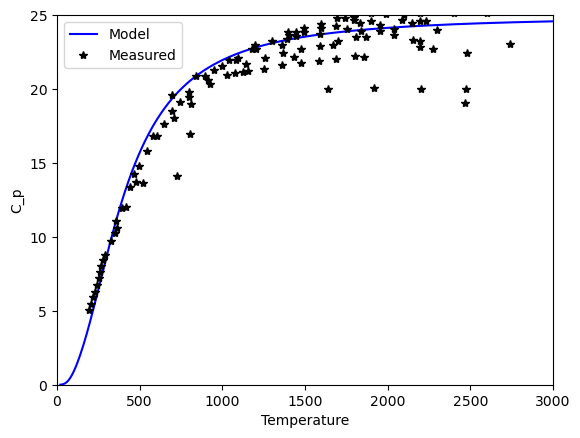

MAE of C6 Cp 1.3137 J/mol.K


In [13]:
# convert data
T_maximum_plot = 3000
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
plt.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
plt.plot(Ts_measured_C6, Cps_measured_C6, 'k*', label = 'Measured')
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("C_p")
plt.xlim([0,T_maximum_plot])
plt.ylim([0,25])
plt.show()

# calculate error
Cps_calculated = []
for i in range(0, len(Ts_measured_C6)):
    T_now = Ts_measured_C6[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
_Cps_measured_C6 = Cps_measured_C6.numpy()
error = np.mean(np.abs(_Cps_measured_C6-Cps_calculated)) # get rid of NaN
print("MAE of C6 Cp %.4f J/mol.K" %error)

Next we show fitted Cp of LiC6

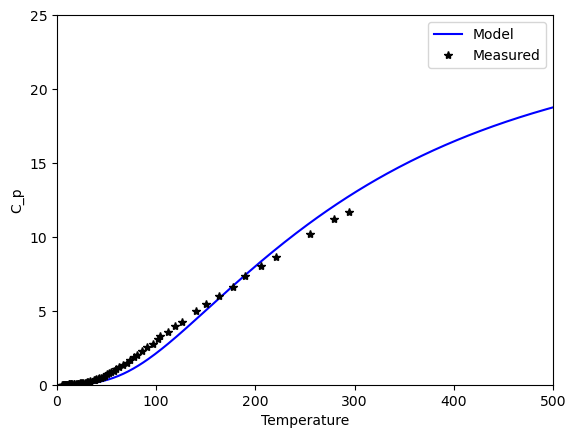

MAE of LiC6 Cp 1.2201 J/mol.K


In [14]:
# convert data
T_maximum_plot = 500
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([1.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
plt.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
plt.plot(Ts_measured_LiC6, Cps_measured_LiC6, 'k*', label = 'Measured')
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("C_p")
plt.xlim([0,T_maximum_plot])
plt.ylim([0,25])
plt.show()

# calculate error
Cps_calculated = []
for i in range(0, len(Ts_measured_LiC6)):
    T_now = Ts_measured_LiC6[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
_Cps_measured_LiC6 = Cps_measured_LiC6.numpy()
error = np.mean(np.abs(_Cps_measured_LiC6[20:]-Cps_calculated[20:])) # get rid of NaN
print("MAE of LiC6 Cp %.4f J/mol.K" %error)

In [15]:
# Cps_calculated

Show Excess H_vib and S_vib of LixC6 comparing with xLiC6 + (1-x)C6

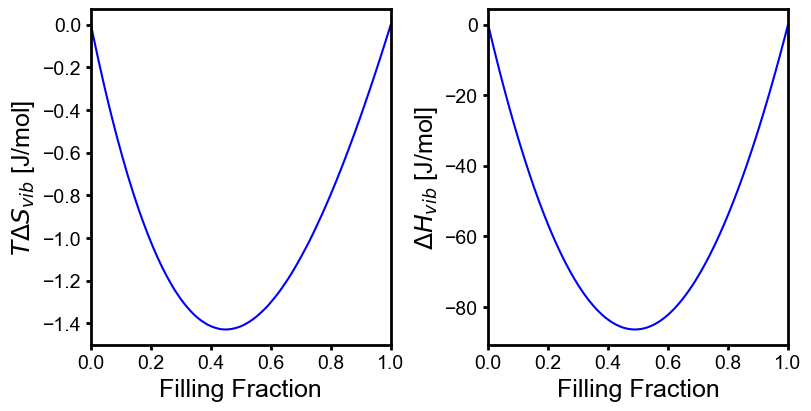

In [16]:
Theta_max_0 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
H_vib_HM = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max_0, is_x_dependent = True, x = torch.tensor([0.0]), T = 300, quaderature_points=quaderature_points, style = "Legendre")
S_vib_HM = _S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max_0, is_x_dependent = True, x = torch.tensor([0.0]), T = 300, quaderature_points=quaderature_points, style = "Legendre")
Theta_max_1 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
H_vib_LiHM = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max_1, is_x_dependent = True, x = torch.tensor([1.0]), T = 300, quaderature_points=quaderature_points, style = "Legendre")
S_vib_LiHM = _S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max_1, is_x_dependent = True, x = torch.tensor([1.0]), T = 300, quaderature_points=quaderature_points, style = "Legendre")


xs = np.linspace(0, 1, 101).astype("float32")
xs = torch.from_numpy(xs)
H_excess_list = []
TS_excess_list = []
for x in xs:
    Theta_max_x = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([x]), style = style)
    H_vib_LixHM = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max_x, is_x_dependent = True, x = torch.tensor([x]), T = 300, quaderature_points=quaderature_points, style = "Legendre")
    H_excess_now = H_vib_LixHM - (x*H_vib_LiHM + (1-x)*H_vib_HM)
    H_excess_list.append(H_excess_now.detach().numpy().tolist()[0])
    S_vib_LixHM = _S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max_x, is_x_dependent = True, x = torch.tensor([x]), T = 300, quaderature_points=quaderature_points, style = "Legendre")
    TS_excess_now = (S_vib_LixHM - x*S_vib_LiHM - (1-x)*S_vib_HM)*300
    TS_excess_list.append(TS_excess_now.detach().numpy().tolist()[0])


# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')
# fig, axes = plt.subplots(3,2, figsize=(8.7,12.95),layout='constrained')

# TS_excess
ax_now = axes[0]
ax_now.plot(xs, TS_excess_list, "b-")
# ax_now.plot(xs, np.array(TS_excess_list)/300, "b-")
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$T\Delta S_{vib}$ [J/mol]', fontsize=18)
# ax_now.set_ylabel(r'$\Delta S_{vib}$ [J/(mol.K)]', fontsize=18)
# ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# H_excess
ax_now = axes[1]
ax_now.plot(xs, H_excess_list, "b-")
# ax_now.plot(xs, np.array(H_excess_list)-np.array(TS_excess_list), "r--")
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta H_{vib}$ [J/mol]', fontsize=18)
# ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# # G_excess
# ax_now = axes[2]
# ax_now.plot(xs, np.array(H_excess_list)-np.array(TS_excess_list), "b-")
# ax_now.set_xlabel('Filling Fraction', fontsize=18)
# ax_now.set_ylabel(r'$\Delta G_{vib}$ [J/mol]', fontsize=18)
# # ax_now.legend(frameon=False, fontsize=14)
# ax_now.set_xlim([0,1])
# ax_now.xaxis.set_tick_params(labelsize=14)
# ax_now.yaxis.set_tick_params(labelsize=14)
# for axis in ['top','bottom','left','right']:
#     ax_now.spines[axis].set_linewidth(2)
# ax_now.tick_params(width=2)

## Show fitted S_mix

we compare the fitted S_mix with ideal mixing entropy

In [17]:
x_calculated = np.linspace(0.01,0.99,1000).astype("float32")
x_calculated = torch.from_numpy(x_calculated)
dsdx_calculated = torch.zeros(len(x_calculated))
s_calculated = torch.zeros(len(x_calculated))
s_ideals = torch.zeros(len(x_calculated))
for i in range(0, len(x_calculated)):
    x = x_calculated[i]
    x = x.requires_grad_()
    s_config_tot, s_ideal, _ = calculate_S_config_total(x, S_config_params_list, style = "Legendre")
    s_ideals[i] = s_ideal
    Theta_max_LixHM = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x, style = style)
    Theta_max_LixHM = Theta_max_LixHM.detach()
    s_vib_tot = calculate_S_vib_total_PDOS(x, 320, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_LixHM, Theta_max_HM, Theta_max_Li, quaderature_points = quaderature_points, style=style)
    s_tot = s_config_tot + s_vib_tot
    s_calculated[i] = s_config_tot
    ds_dx = autograd.grad(outputs=s_tot, inputs=x, create_graph=True)[0]
    dsdx_calculated[i] = ds_dx



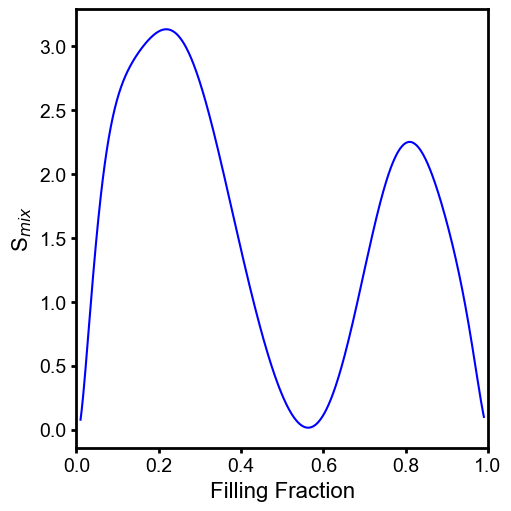

In [18]:

# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
fig, ax = plt.subplots(1,1, figsize=(5,5),layout='constrained')
_x1 = x_calculated.numpy()
_y1 = s_calculated.detach().numpy()
ax.plot(_x1, _y1, "b-", label = 'Model')
_y1 = s_ideals.detach().numpy()
# ax.plot(_x1, _y1, "k-", label = 'Ideal')
# ax.legend()
ax.set_xlabel('Filling Fraction', fontsize=16)
ax.set_ylabel(r'S$_{mix}$', fontsize=16)
# ax.set_xlim([0.54,0.57])
ax.set_xlim([0,1])
# ax.set_ylim([0,0.1])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)
# plt.savefig("Figure_for_workflow_smix.png", dpi=200)

## Evaluate fitted dsdx

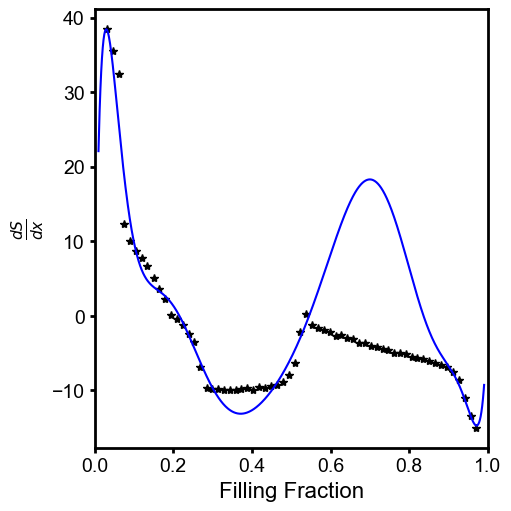

In [19]:

# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
fig, ax = plt.subplots(1,1, figsize=(5,5),layout='constrained')
_x = x_measured_dsdx.numpy()
_y = dsdx_measured.numpy()
ax.plot(_x, _y, "k*", label=r'Measured ')
_x1 = x_calculated.numpy()
_y1 = dsdx_calculated.detach().numpy()
ax.plot(_x1, _y1, "b-", label=r'Model')
# ax.legend()
ax.set_xlabel('Filling Fraction', fontsize=16)
ax.set_ylabel(r'$\frac{dS}{dx}$', fontsize=16)
ax.set_xlim([0,1])
# ax.set_ylim([0,6])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)
# plt.savefig("Figure_for_workflow_dsdx.png", dpi=200)


## Evaluate Fitted OCV

In [20]:
# define a helper function
def _calculate_OCV(x_measured, GibbsFE, total_params_list, T, style="Legendre", quaderature_points=5):
    phase_boundary_fixed_point = _get_phase_boundaries(GibbsFE, total_params_list, T, style = style, quaderature_points = quaderature_points, ngrid=99)
    # first predict the one before common tangent
    mu_pred = []
    for i in range(0, len(x_measured)):
        x_now = x_measured[i]
        x_now = x_now.requires_grad_()
        g_now = GibbsFE(x_now, T, total_params_list, style = style, quaderature_points = quaderature_points)
        mu_pred_now = autograd.grad(outputs=g_now, inputs=x_now, create_graph=True)[0]
        mu_pred.append(mu_pred_now.detach().numpy())
    mu_pred = np.array(mu_pred)
    # calculate mu after common tangent construction
    mu_pred_after_ct = []
    # see if x is inside any gaps
    def _is_inside_gaps(_x, _gaps_list):
        _is_inside = False
        _index = -99999
        for i in range(0, len(_gaps_list)):
            if _x >= _gaps_list[i][0] and _x <= _gaps_list[i][1]:
                _is_inside = True
                _index = i
                break
        return _is_inside, _index
    # pred
    for i in range(0, len(x_measured)):
        x_now = x_measured[i]
        is_inside, index = _is_inside_gaps(x_now, phase_boundary_fixed_point)
        if is_inside == False:
            # outside miscibility gap 
            mu_pred_after_ct.append(mu_pred[i])
        else: 
            # inside miscibility gap
            x_alpha = phase_boundary_fixed_point[index][0]
            x_beta = phase_boundary_fixed_point[index][1]
            ct_pred = (GibbsFE(x_alpha, T, total_params_list, style = style, quaderature_points = quaderature_points) - GibbsFE(x_beta, T, total_params_list, style = style, quaderature_points = quaderature_points))/(x_alpha - x_beta) 
            if torch.isnan(ct_pred) == False:
                mu_pred_after_ct.append(ct_pred.clone().detach().numpy()) 
            else:
                mu_pred_after_ct.append(mu_pred[i])
    mu_pred_after_ct = np.array(mu_pred_after_ct)
    U_pred_after_ct = mu_pred_after_ct/(-96485)
    return U_pred_after_ct
    

In [21]:
U1 = _calculate_OCV(x1, GibbsFE, total_params_list, T1)
U2 = _calculate_OCV(x2, GibbsFE, total_params_list, T2)
U3 = _calculate_OCV(x3, GibbsFE, total_params_list, T3)
U4 = _calculate_OCV(x4, GibbsFE, total_params_list, T4)

Average MAE is 2.9022 mV


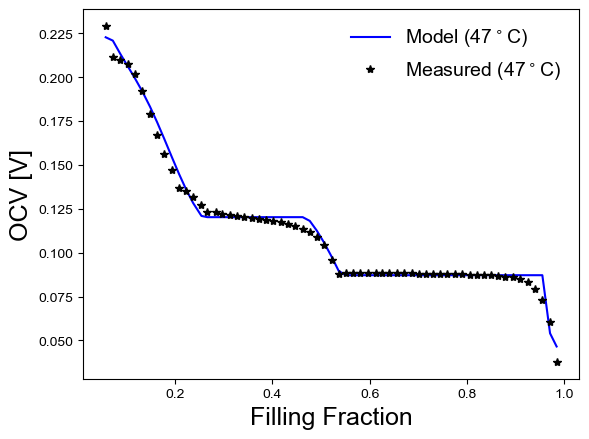

In [22]:
plt.plot(x1.numpy(), U1, "b-", label=r'Model (47$^\circ$C)')
plt.plot(x1.numpy(), mu1.numpy()/-96485, "k*", label=r'Measured (47$^\circ$C)')
plt.xlabel('Filling Fraction', fontsize=18)
plt.ylabel('OCV [V]', fontsize=18)
plt.legend(frameon=False, fontsize=14)
error = np.mean(np.abs(U1-(mu1.numpy()/-96485)))
print("Average MAE is %.4f mV" %(error*1000))

Average MAE is 3.0035 mV


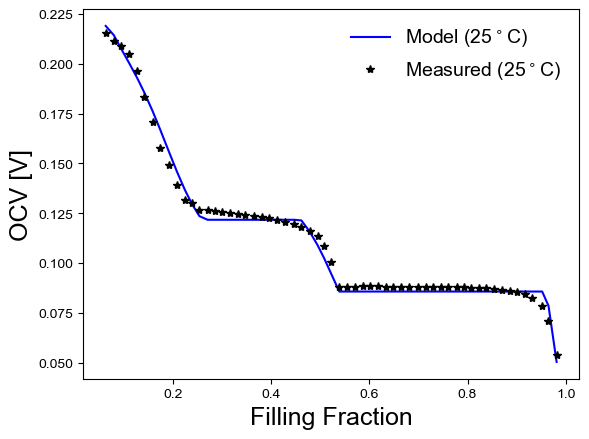

In [23]:
plt.plot(x2.numpy(), U2, "b-", label=r'Model (25$^\circ$C)')
plt.plot(x2.numpy(), mu2.numpy()/-96485, "k*", label=r'Measured (25$^\circ$C)')
plt.xlabel('Filling Fraction', fontsize=18)
plt.ylabel('OCV [V]', fontsize=18)
plt.legend(frameon=False, fontsize=14)
error = np.mean(np.abs(U2-(mu2.numpy()/-96485)))
print("Average MAE is %.4f mV" %(error*1000))

Average MAE is 3.6427 mV


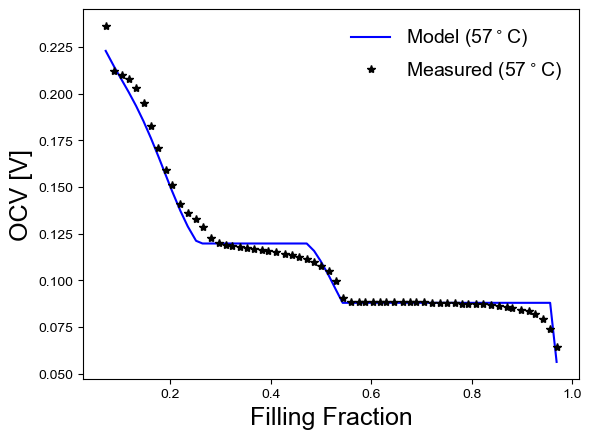

In [24]:
plt.plot(x3.numpy(), U3, "b-", label=r'Model (57$^\circ$C)')
plt.plot(x3.numpy(), mu3.numpy()/-96485, "k*", label=r'Measured (57$^\circ$C)')
plt.xlabel('Filling Fraction', fontsize=18)
plt.ylabel('OCV [V]', fontsize=18)
plt.legend(frameon=False, fontsize=14)
error = np.mean(np.abs(U3-(mu3.numpy()/-96485)))
print("Average MAE is %.4f mV" %(error*1000))

Average MAE is 3.8125 mV (Extrapolation)


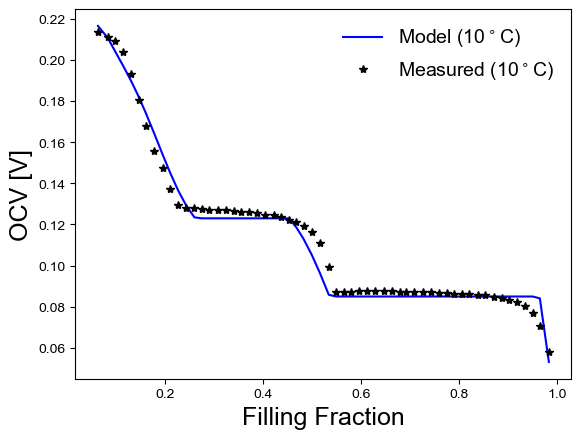

In [25]:
plt.plot(x4.numpy(), U4, "b-", label=r'Model (10$^\circ$C)')
plt.plot(x4.numpy(), mu4.numpy()/-96485, "k*", label=r'Measured (10$^\circ$C)')
plt.xlabel('Filling Fraction', fontsize=18)
plt.ylabel('OCV [V]', fontsize=18)
plt.legend(frameon=False, fontsize=14)
error = np.mean(np.abs(U4-(mu4.numpy()/-96485)))
print("Average MAE is %.4f mV (Extrapolation)" %(error*1000))

# Now, let us plot the figures for publication

First let's plot a figure about how did we do the S_pretrain (with fit_dsdx): (a) Fitted dsdx, (b) fitted s_config vs s_ideal, the Cp of LixHM collapses to (c) C6 and (d) LiC6 at x=0 and 1

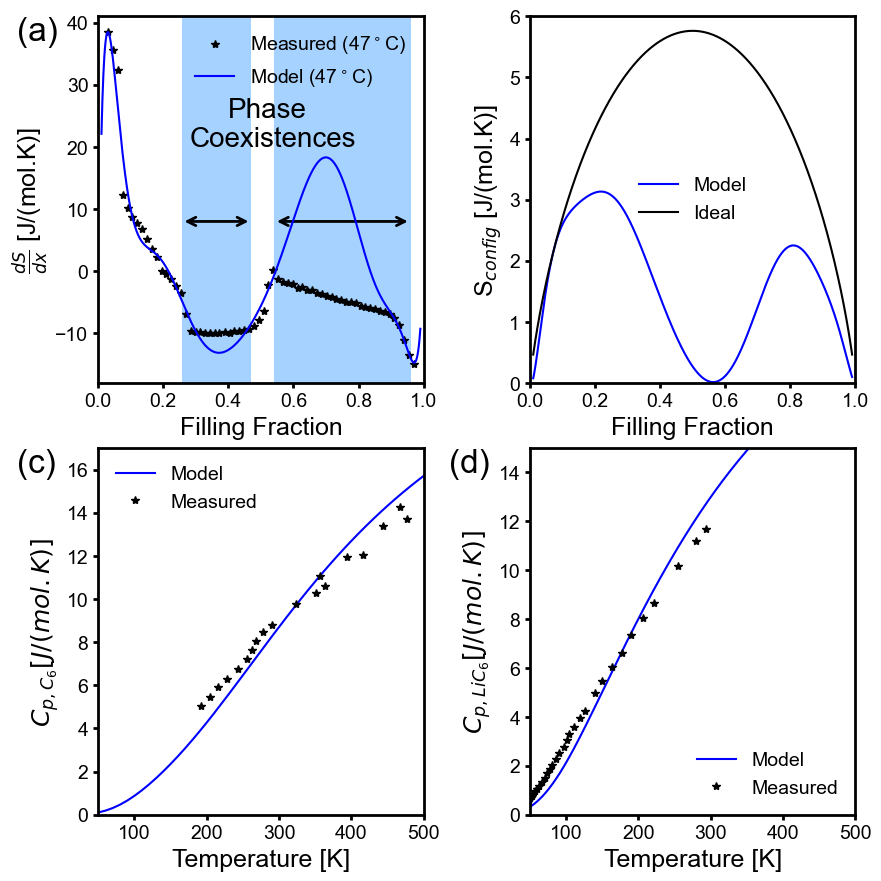

In [26]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch


fig, axes = plt.subplots(2,2, figsize=(8.7,8.7),layout='constrained')
# fig, axes = plt.subplots(3,2, figsize=(8.7,12.95),layout='constrained')

# fitted dsdx
ax_now = axes[0][0]
ax_now.plot(x_measured_dsdx, dsdx_measured, "k*", label=r'Measured (47$^\circ$C)')
ax_now.plot(x_calculated, dsdx_calculated.detach(), "b-", label=r'Model (47$^\circ$C)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\frac{dS}{dx}$ [J/(mol.K)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.set_ylim([-18,41])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


# [[0.2563, 0.4705], 320]
# [[0.5406, 0.9601], 320]
rect = patches.Rectangle(
    (0.2563, -20),               # bottom left corner (x0, y0)
    0.4705-0.2563,                   # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.2563, 8)
end = (0.4705, 8)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)



rect = patches.Rectangle(
    (0.5406, -20),               # bottom left corner (x0, y0)
    0.9601-0.5406,                   # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.5406, 8)
end = (0.9601, 8)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)

# add label
ax_now.text(
    0.4, 0.78, 'Phase',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.28, 0.7, 'Coexistences',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)

# add label
ax_now.text(
    -0.25, 1, '(a)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

# fitted dsdx
ax_now = axes[0][1]
_x1 = x_calculated.numpy()
_y1 = s_calculated.detach().numpy()
ax_now.plot(_x1, _y1, "b-", label = 'Model')
_y1 = s_ideals.detach().numpy()
ax_now.plot(_x1, _y1, "k-", label = 'Ideal')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'S$_{config}$ [J/(mol.K)]', fontsize=18)
ax_now.set_xlim([0,1])
ax_now.set_ylim([0,6])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
# [[0.2563, 0.4705], 320]
# [[0.5406, 0.9601], 320]
# rect = patches.Rectangle(
#     (0.2563, -20),               # bottom left corner (x0, y0)
#     0.4705-0.2563,                   # width
#     100,                   # height
#     linewidth=1,
#     edgecolor='none',
#     facecolor='#1E90FF',  
#     alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
# )
# ax_now.add_patch(rect)
# rect = patches.Rectangle(
#     (0.5406, -20),               # bottom left corner (x0, y0)
#     0.9601-0.5406,                   # width
#     100,                   # height
#     linewidth=1,
#     edgecolor='none',
#     facecolor='#1E90FF',  
#     alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
# )
# ax_now.add_patch(rect)
# ax_now.text(
#     -0.25, 1, '(b)',           # x, y position in axes fraction
#     transform=ax_now.transAxes,      # interpret coords as fraction of axes
#     fontsize=24,
#     fontweight='normal',
#     va='top',
#     ha='left'
# )


# Cp of HM
ax_now = axes[1][0]

T_maximum_plot = 3000
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([0.0]), style = style)
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([0.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
ax_now.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
ax_now.plot(Ts_measured_C6[:20], Cps_measured_C6[:20], 'k*', label = 'Measured')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel("Temperature [K]", fontsize=18)
ax_now.set_ylabel("$C_{p, C_6} [J/(mol.K)]$", fontsize=18)
ax_now.set_xlim([50,500])
ax_now.set_ylim([0,17])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
ax_now.text(
    -0.25, 1, '(c)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

## now Cp of LiC6
ax_now = axes[1][1]
T_maximum_plot = 400
Ts_calculated = torch.from_numpy(np.linspace(0.,T_maximum_plot,300).astype("float32"))
Cps_calculated = []
Theta_max = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = torch.tensor([1.0]), style = style)
for i in range(0, len(Ts_calculated)):
    T_now = Ts_calculated[i]
    T_now = T_now.requires_grad_()
    H_vib_now = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, Theta_max = Theta_max, quaderature_points=quaderature_points, is_x_dependent = True, x = torch.tensor([1.0]), T = T_now, style = "Legendre")
    Cp_calculated_now = autograd.grad(outputs=H_vib_now, inputs=T_now, create_graph=True)[0]
    Cp_calculated_now = Cp_calculated_now.detach().numpy().tolist()
    Cps_calculated.append(Cp_calculated_now)
Cps_calculated = np.array(Cps_calculated)
Ts_calculated = Ts_calculated.numpy()
# plot figure
ax_now.plot(Ts_calculated, Cps_calculated, "b-", label='Model')
ax_now.plot(Ts_measured_LiC6, Cps_measured_LiC6, 'k*', label = 'Measured')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel("Temperature [K]", fontsize=18)
ax_now.set_ylabel("$C_{p, LiC_6} [J/(mol.K)]$", fontsize=18)
ax_now.set_xlim([50,500])
ax_now.set_ylim([0,15])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
ax_now.text(
    -0.25, 1, '(d)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

plt.savefig("Figure_graphite_Cp_S.pdf", format='pdf', bbox_inches='tight')

Next, we plot (a) Fitted OCV at 47C vs experiment and report error, (b) dQdV analysis, (c) fitted OCV at 10 C(extrapolation) vs experiment and report error, and (d) maybe plot the pseudo-phase diagram of LixC6???

In [27]:
# define a helper function
def _calculate_dVdQ(x_measured, GibbsFE, total_params_list, T, style="Legendre", quaderature_points=5):
    phase_boundary_fixed_point = _get_phase_boundaries(GibbsFE, total_params_list, T, style = style, quaderature_points = quaderature_points, ngrid=99)
        # see if x is in any gaps
    def _is_inside_gaps(_x, _gaps_list):
        _is_inside = False
        _index = -99999
        if len(_gaps_list) == 0:
            return False, -99999
        for i in range(0, len(_gaps_list)):
            if _x >= _gaps_list[i][0] and _x <= _gaps_list[i][1]:
                _is_inside = True
                _index = i
                break
        return _is_inside, _index

    OCV_calculated = []
    dOCV_calculated_dx = [] # this is dVdQ, dQdV is 1/dVdQ
    # dOCV_calculated_dT = []
    # d2OCV_calculated_dT_dx = [] # first do dT, then dx
    # d2OCV_calculated_dx_dT = [] # first do dx, then dT
    for i in range(0, len(x_measured)):
        x_now = x_measured[i]
        is_inside, index = _is_inside_gaps(x_now, phase_boundary_fixed_point)
        if is_inside == False:
            # outside miscibility gap 
            x_now = x_now.requires_grad_()
            g_now = GibbsFE(x_now, T, total_params_list, style = style, quaderature_points = quaderature_points)
            mu_pred_now = autograd.grad(outputs=g_now, inputs=x_now, create_graph=True)[0]
            OCV_calculated_now = -mu_pred_now/96485
            OCV_calculated.append(OCV_calculated_now)
            dOCV_calculated_dx_now = autograd.grad(outputs=OCV_calculated_now, inputs=x_now, create_graph=True)[0]
            dOCV_calculated_dx.append(dOCV_calculated_dx_now)
        else: 
            # inside miscibility gap
            x_alpha = phase_boundary_fixed_point[index][0]
            x_beta = phase_boundary_fixed_point[index][1]
            ct_pred = ( GibbsFE(x_alpha, T, total_params_list, style = style, quaderature_points = quaderature_points) - GibbsFE(x_beta, T, total_params_list, style = style, quaderature_points = quaderature_points) )/(x_alpha - x_beta) 
            if torch.isnan(ct_pred):
                print("Common tangent is NaN")
                x_alpha = 99999.9
                x_beta = -99999.9
            if x_alpha > x_beta:
                print("Error in phase equilibrium boundary, x_left %.4f larger than x_right %.4f. If Hessian loss is not 0, it's fine. Otherwise check code carefully!" %(x_alpha, x_beta))
                x_alpha = 99999.9
                x_beta = -99999.9
            if torch.isnan(ct_pred):
                print("Warning: skipped for loss calculation at a filling fraction x")
            else:
                OCV_calculated_now = -ct_pred/96485
                OCV_calculated.append(OCV_calculated_now)
                # dOCV_calculated_dx_now = autograd.grad(outputs=OCV_calculated_now, inputs=x_now, create_graph=True)[0]
                dOCV_calculated_dx.append(torch.tensor(-1e-7))  
    for i in range(0, len(dOCV_calculated_dx)):
        dOCV_calculated_dx[i] = dOCV_calculated_dx[i].detach().numpy().tolist()
    dOCV_calculated_dx = torch.tensor(dOCV_calculated_dx)
    return dOCV_calculated_dx

In [28]:
# calculate dVdQ at 320K from model
_x1 = torch.from_numpy(np.linspace(0.06, 0.99, 100).astype("float32"))
U1_dvdq = _calculate_OCV(_x1, GibbsFE, total_params_list, T1)
dVdQ_1_calculated = _calculate_dVdQ(_x1, GibbsFE, total_params_list, T1, style="Legendre", quaderature_points=5)

In [29]:
# calculate dVdQ at 320K from experimental measured OCV 
df = pd.read_csv("47C_lithiation.csv",header=None) # deleted those datapoints within miscibility gaps
data = df.to_numpy()
x_320K = data[:,0] # Li filling fraction of graphite, from 0 to 1
OCV_320K = data[:,1] 

dQdV_320K = np.zeros_like(OCV_320K)
dQdV_320K[0] = (x_320K[1]-x_320K[0])/(OCV_320K[1]-OCV_320K[0])
for i in range(1, len(OCV_320K)):
    dQdV_320K[i] = np.abs((x_320K[i]-x_320K[i-1])/(OCV_320K[i]-OCV_320K[i-1]))


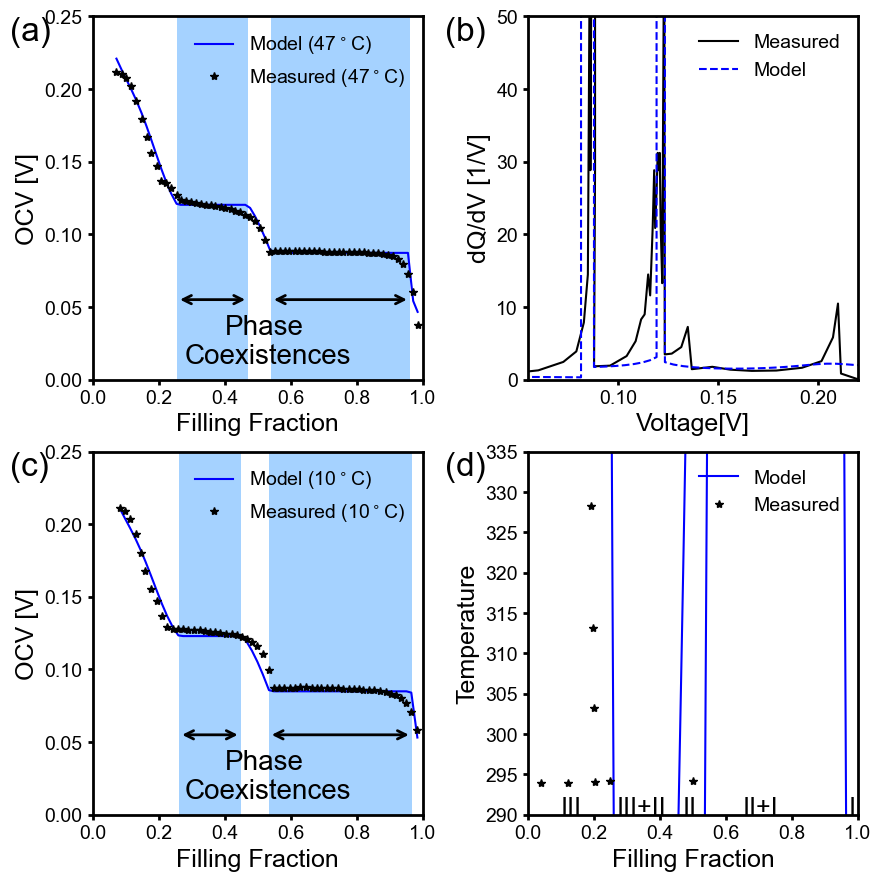

In [50]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch


fig, axes = plt.subplots(2,2, figsize=(8.7,8.7),layout='constrained')

# OCV at 47C vs experiment 
ax_now = axes[0][0]
ax_now.plot(x1.numpy()[1:], U1[1:], "b-", label=r'Model (47$^\circ$C)')
ax_now.plot(x1.numpy()[1:], mu1.numpy()[1:]/-96485, "k*", label=r'Measured (47$^\circ$C)')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel('OCV [V]', fontsize=18)
ax_now.set_ylim([0,0.25])
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

rect = patches.Rectangle(
    (0.2563,  -20),               # bottom left corner (x0, y0)
    0.4705-0.2563,                  # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
# [[0.2563, 0.4705], 320]
# [[0.5406, 0.9601], 320]
start = (0.2563, 0.055)
end = (0.4705, 0.055)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)

rect = patches.Rectangle(
    (0.5406, -20),               # bottom left corner (x0, y0)
    0.9601-0.5406,                   # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.5406, 0.055)
end = (0.9601, 0.055)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)

# add label
ax_now.text(
    0.4, 0.18, 'Phase',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.28, 0.1, 'Coexistences',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)

# add label
ax_now.text(
    -0.25, 1, '(a)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

# dQdV VS experiment
ax_now = axes[0][1]
ax_now.plot(OCV_320K, dQdV_320K, 'k-', label='Measured')
ax_now.plot(U1_dvdq, -(1/(dVdQ_1_calculated)).numpy(), 'b--', label='Model')
ax_now.set_xlabel('Voltage[V]', fontsize=18)
ax_now.set_ylabel('dQ/dV [1/V]', fontsize=18)
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0.055,0.22])
ax_now.set_ylim([0.0, 50])
# add label
ax_now.text(
    -0.25, 1, '(b)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

# OCV at 10C 
ax_now = axes[1][0]
ax_now.plot(x4.numpy()[1:], U4[1:], "b-", label=r'Model (10$^\circ$C)')
ax_now.plot(x4.numpy()[1:], mu4.numpy()[1:]/-96485, "k*", label=r'Measured (10$^\circ$C)')
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel('OCV [V]', fontsize=18)
ax_now.set_ylim([0,0.25])
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

rect = patches.Rectangle(
    (0.2628,  -20),               # bottom left corner (x0, y0)
    0.4479-0.2628,                  # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.2628, 0.055)
end = (0.4479, 0.055)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)

rect = patches.Rectangle(
    (0.5340, -20),               # bottom left corner (x0, y0)
    0.9660-0.5340,                   # width
    100,                   # height
    linewidth=1,
    edgecolor='none',
    facecolor='#1E90FF',  
    alpha=0.4,  # transparency (0 = fully transparent, 1 = fully opaque)
)
ax_now.add_patch(rect)
# Add bidirectional arrow
start = (0.5340, 0.055)
end = (0.9660, 0.055)
arrow = FancyArrowPatch(
    start, end,
    arrowstyle='<->',
    mutation_scale=15,  # size of arrow heads
    color='black',
    linewidth=2
)
ax_now.add_patch(arrow)

# add label
ax_now.text(
    0.4, 0.18, 'Phase',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.28, 0.1, 'Coexistences',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=20,
    fontweight='normal',
    va='top',
    ha='left'
)
# add label
ax_now.text(
    -0.25, 1, '(c)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

# pseudo phase diagram??
ax_now = axes[1][1]

phase1 = [[[0.2628, 0.4479], 273],\
[[0.2618, 0.4514], 280],\
[[0.2603, 0.4564], 290],\
[[0.2589, 0.4612], 300],\
[[0.2563, 0.4705], 320],\
[[0.2545, 0.4772], 335]]

phase2 = [[[0.5340, 0.9660], 273],\
[[0.5350, 0.9651], 280],\
[[0.5364, 0.9638], 290],\
[[0.5378, 0.9626], 300],\
[[0.5406, 0.9601], 320],\
[[0.5428, 0.9584], 335]]

x_left_phase_1 = []
x_right_phase_1 = []
T_phase_1 = []
for i in range(0, len(phase1)):
    x_left_phase_1.append(phase1[i][0][0])
    x_right_phase_1.append(phase1[i][0][1])
    T_phase_1.append(phase1[i][1])
x_left_phase_1 = np.array(x_left_phase_1)
x_right_phase_1 = np.array(x_right_phase_1)
T_phase_1 = np.array(T_phase_1)

x_left_phase_2 = []
x_right_phase_2 = []
T_phase_2 = []
for i in range(0, len(phase2)):
    x_left_phase_2.append(phase2[i][0][0])
    x_right_phase_2.append(phase2[i][0][1])
    T_phase_2.append(phase2[i][1])
x_left_phase_2 = np.array(x_left_phase_2)
x_right_phase_2 = np.array(x_right_phase_2)
T_phase_2 = np.array(T_phase_2)

### pd calculated without vib temperature dependency
phase1 = [[[0.5361, 0.9639], 290],\
[[0.5395, 0.9613], 310],\
[[0.5439, 0.9582], 330]]

phase2 = [[[0.2600, 0.4567], 290],\
[[0.2579, 0.4656], 310],\
[[0.2553, 0.4762], 330]]

x_left_phase_1_no_vib = []
x_right_phase_1_no_vib = []
T_phase_1_no_vib = []
for i in range(0, len(phase1)):
    x_left_phase_1_no_vib.append(phase1[i][0][0])
    x_right_phase_1_no_vib.append(phase1[i][0][1])
    T_phase_1_no_vib.append(phase1[i][1])
x_left_phase_1_no_vib = np.array(x_left_phase_1_no_vib)
x_right_phase_1_no_vib = np.array(x_right_phase_1_no_vib)
T_phase_1_no_vib = np.array(T_phase_1_no_vib)

x_left_phase_2_no_vib = []
x_right_phase_2_no_vib = []
T_phase_2_no_vib = []
for i in range(0, len(phase2)):
    x_left_phase_2_no_vib.append(phase2[i][0][0])
    x_right_phase_2_no_vib.append(phase2[i][0][1])
    T_phase_2_no_vib.append(phase2[i][1])
x_left_phase_2_no_vib = np.array(x_left_phase_2_no_vib)
x_right_phase_2_no_vib = np.array(x_right_phase_2_no_vib)
T_phase_2_no_vib = np.array(T_phase_2_no_vib)

# Jeff Dahn Measurements
phase_measured_x = [0.20285714968149066, 0.19956934953388, 0.19697183216335573, 0.1912584882090625, 0.18865738805595827,   0.49981608382755827,       0.120584157, 0.039752126, 0.250399224] #, 0.298649448, 0.40030185
phase_measured_T = [20.844605165417086, 30.01652857030256, 39.93259591706098,  55.0537297960919,  65.0524399943631,  20.991857529456453,          20.82295629, 20.78287429, 21.02741497] # , 9.844334913, 9.894741062
phase_measured_x = np.array(phase_measured_x)
phase_measured_T = np.array(phase_measured_T)+273.15

# Jeff Dahn dotted lines
x_b1 = np.array([0.038876, 0.04651])
T_b1 = np.array([69.2523, 0.0]) + 273.15
x_b2 = np.array([0.11968, 0.12025])
T_b2 = np.array([69.85, 0.0])+ 273.15
x_b3 = np.array([0.18704, 0.20843])
T_b3 = np.array([69.887, 0.0])+ 273.15
x_b4 = np.array([0.24955, 0.24967])
T_b4 = np.array([69.887,9.68 ])+ 273.15
x_b5 = np.array([0.49935, 0.500])
T_b5 = np.array([70, 0])+ 273.15
x_b6 = np.array([0.20435, 0.49952])
T_b6 = np.array([9.68, 9.68])+ 273.15


# plot calculated pd
ax_now.plot(x_left_phase_1, T_phase_1, 'b-', label='Model')
ax_now.plot(x_right_phase_1, T_phase_1, 'b-')
ax_now.plot(x_left_phase_2, T_phase_2, 'b-')
ax_now.plot(x_right_phase_2, T_phase_2, 'b-')

# # plot calculated pd, but without vib temperature dependency
# ax_now.plot(x_left_phase_1_no_vib, T_phase_1_no_vib, 'b--', label='Model (Vib Fixed)')
# ax_now.plot(x_right_phase_1_no_vib, T_phase_1_no_vib, 'b--')
# ax_now.plot(x_left_phase_2_no_vib, T_phase_2_no_vib, 'b--')
# ax_now.plot(x_right_phase_2_no_vib, T_phase_2_no_vib, 'b--')


# plot Jeff's actual measurements
ax_now.plot(phase_measured_x, phase_measured_T, "k*", label='Measured')
# # plot Jeff's dotted lines
# ax_now.plot(x_b1, T_b1, "k--")
# ax_now.plot(x_b2, T_b2, "k--")
# ax_now.plot(x_b3, T_b3, "k--")
# ax_now.plot(x_b4, T_b4, "k--")
# ax_now.plot(x_b5, T_b5, "k--")
# ax_now.plot(x_b6, T_b6, "k--")


ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel('Temperature', fontsize=18)
ax_now.set_ylim([290,335])
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

ax_now.text(
    0.1, 0.05, 'III',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.27, 0.05, 'III+II',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.47, 0.05, 'II',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.65, 0.05, 'II+I',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.97, 0.05, 'I',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)

# add label
ax_now.text(
    -0.25, 1, '(d)',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=24,
    fontweight='normal',
    va='top',
    ha='left'
)

plt.savefig("Figure_graphite_OCV.pdf", format='pdf', bbox_inches='tight')

Calculate Phase Boundary with everything turned on

In [31]:
# phase_boundary_fixed_point_273 = _get_phase_boundaries(GibbsFE, total_params_list, 273, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_280 = _get_phase_boundaries(GibbsFE, total_params_list, 280, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_285 = _get_phase_boundaries(GibbsFE, total_params_list, 285, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_290 = _get_phase_boundaries(GibbsFE, total_params_list, 290, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_295 = _get_phase_boundaries(GibbsFE, total_params_list, 295, style = style, quaderature_points = quaderature_points, ngrid=99)
phase_boundary_fixed_point_300 = _get_phase_boundaries(GibbsFE, total_params_list, 300, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_305 = _get_phase_boundaries(GibbsFE, total_params_list, 305, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_310 = _get_phase_boundaries(GibbsFE, total_params_list, 310, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_315 = _get_phase_boundaries(GibbsFE, total_params_list, 315, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_320 = _get_phase_boundaries(GibbsFE, total_params_list, 320, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_325 = _get_phase_boundaries(GibbsFE, total_params_list, 325, style = style, quaderature_points = quaderature_points, ngrid=99)
phase_boundary_fixed_point_330 = _get_phase_boundaries(GibbsFE, total_params_list, 330, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_335 = _get_phase_boundaries(GibbsFE, total_params_list, 335, style = style, quaderature_points = quaderature_points, ngrid=99)



In [38]:
# print(phase_boundary_fixed_point_300[3], phase_boundary_fixed_point_330[3])
# print("%.10f" %phase_boundary_fixed_point_330[3][1])
print(phase_boundary_fixed_point_330[1])

tensor([0.5421, 0.9589], grad_fn=<CatBackward0>)


In [33]:
# [[0.2628, 0.4479], 273]
# [[0.2618, 0.4514], 280]
# [[0.2603, 0.4564], 290]
# [[0.2589, 0.4612], 300]
# [[0.2563, 0.4705], 320]
# [[0.2545, 0.4772], 335]

# [[0.5340, 0.9660], 273]
# [[0.5350, 0.9651], 280]
# [[0.5364, 0.9638], 290]
# [[0.5378, 0.9626], 300]
# [[0.5406, 0.9601], 320]
# [[0.5428, 0.9584], 335]



Now let's turn off temperature dependency of vib terms, and calculate phase boundary again (i.e. with S_config only)

The intuition behind: the contribution of H_vib and S_vib are relatively small compared with S_config, the phase boundary is mainly controlled by S_config -- at high temperature, it's mainly entropy stabilizing, i.e. G is minimized because -T*S is more and more important, and therefore the slope of phase boundary implies which side has larger entropy

In [39]:
from diffthermo.energy import legendre_poly_recurrence, calculate_H_vib_total_PDOS, calculate_S_vib_total_PDOS
def GibbsFE_no_vib_T_dependency(x, T, params_list, style = "Legendre", quaderature_points = 20):
    """
    Turned off T dependency of Hvib and Svib
    Temperature for Hvib and Svib are fixed at 300K
    """
    _eps = 1e-7
    if style == "Legendre":
        poly_eval_function = legendre_poly_recurrence
    elif style == "Chebyshev":
        poly_eval_function = chebyshev_poly_recurrence
    else:
        print("ERROR: polynomial style %s not supported." %(style))
        exit()
    enthalpy_mixing_params_list = params_list[0]
    config_entropy_params_list = params_list[1]
    n_list = params_list[2]
    g_ij_list_LixHM = params_list[3]
    g_i_list_HM = params_list[4]
    g_i_list_Li = params_list[5]
    Theta_max_HM = params_list[6]
    Theta_max_Li = params_list[7]
    # need to solve Theta_max_LixHM from g_ij_list_LixHM
    x = torch.clamp(x, min=_eps, max=1.0-_eps)
    Theta_max_LixHM = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x, style = style)
    # H_mix
    G0 = enthalpy_mixing_params_list[-1]
    G = x*G0 + (1-x)*0.0 
    t = 2 * x -1 # Transform x to (2x-1) for legendre expansion
    Pn_values = poly_eval_function(t, len(enthalpy_mixing_params_list)-2)  # Compute Legendre polynomials up to degree len(coeffs) - 1 # don't need to get Pn(G0)
    for i in range(0, len(enthalpy_mixing_params_list)-1):
        G = G + x*(1-x)*(enthalpy_mixing_params_list[i]*Pn_values[i])
    # S_mix (S_ideal + S_excess)
    # S_ideal
    G = G - T*(-8.314)*(x*torch.log(x)+(1-x)*torch.log(1-x)) 
    # S_excess, i.e. excess configurational entropy
    t = 2 * x -1 # Transform x to (2x-1) for legendre expansion
    Pn_values = poly_eval_function(t, len(config_entropy_params_list)-1)  # Compute Legendre polynomials up to degree len(coeffs) - 1 
    for i in range(0, len(config_entropy_params_list)):
        G = G - T*(-8.314)*(x*torch.log(x)+(1-x)*torch.log(1-x))*(config_entropy_params_list[i]*Pn_values[i])
    #### NOTE FIX temperature of vib terms at 300K
    # S_vib, i.e. vibrational entropy
    ### NOTE before, I didn't change the T*calculate_S_vib_total_PDOS to be 300, and therefore it still has some kind of temperature dependency
    G = G - 300*calculate_S_vib_total_PDOS(x, 300, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_LixHM, Theta_max_HM, Theta_max_Li, quaderature_points = quaderature_points, style=style)
    # H_vib, i.e. vibrational enthalpy corresponds to the vibrational entropy
    # we need to satisfy dH/dT = T*dS/dT
    G = G + calculate_H_vib_total_PDOS(x, 300, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_LixHM, Theta_max_HM, Theta_max_Li, quaderature_points = quaderature_points, style=style)
    return G


In [40]:
# phase_boundary_fixed_point_290 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 290, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_300 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 300, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_310 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 310, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_320 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 320, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_330 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 330, style = style, quaderature_points = quaderature_points, ngrid=99)
# phase_boundary_fixed_point_335 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 335, style = style, quaderature_points = quaderature_points, ngrid=99)
# # phase_boundary_fixed_point_400 = _get_phase_boundaries(GibbsFE_no_vib_T_dependency, total_params_list, 400, style = style, quaderature_points = quaderature_points, ngrid=99)

In [ ]:
# phase_boundary_fixed_point_335

In [42]:
# [[0.5361, 0.9639], 290]
# [[0.5395, 0.9613], 310]
# [[0.5439, 0.9582], 330]

# [[0.2600, 0.4567], 290]
# [[0.2579, 0.4656], 310]
# [[0.2553, 0.4762], 330]

Draw Phase Diagram with Both Fixed and Changing Vib (for SI):

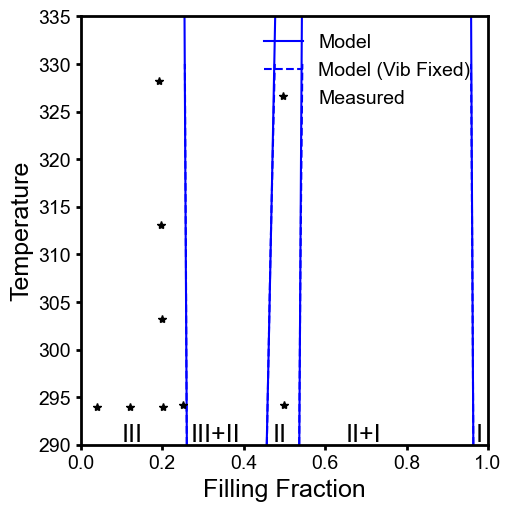

In [49]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch


fig, ax_now = plt.subplots(1,1, figsize=(5,5),layout='constrained')


phase1 = [[[0.2628, 0.4479], 273],\
[[0.2618, 0.4514], 280],\
[[0.2603, 0.4564], 290],\
[[0.2589, 0.4612], 300],\
[[0.2563, 0.4705], 320],\
[[0.2545, 0.4772], 335]]

phase2 = [[[0.5340, 0.9660], 273],\
[[0.5350, 0.9651], 280],\
[[0.5364, 0.9638], 290],\
[[0.5378, 0.9626], 300],\
[[0.5406, 0.9601], 320],\
[[0.5428, 0.9584], 335]]

x_left_phase_1 = []
x_right_phase_1 = []
T_phase_1 = []
for i in range(0, len(phase1)):
    x_left_phase_1.append(phase1[i][0][0])
    x_right_phase_1.append(phase1[i][0][1])
    T_phase_1.append(phase1[i][1])
x_left_phase_1 = np.array(x_left_phase_1)
x_right_phase_1 = np.array(x_right_phase_1)
T_phase_1 = np.array(T_phase_1)

x_left_phase_2 = []
x_right_phase_2 = []
T_phase_2 = []
for i in range(0, len(phase2)):
    x_left_phase_2.append(phase2[i][0][0])
    x_right_phase_2.append(phase2[i][0][1])
    T_phase_2.append(phase2[i][1])
x_left_phase_2 = np.array(x_left_phase_2)
x_right_phase_2 = np.array(x_right_phase_2)
T_phase_2 = np.array(T_phase_2)

### pd calculated without vib temperature dependency
phase1 = [[[0.5361, 0.9639], 290],\
[[0.5395, 0.9613], 310],\
[[0.5439, 0.9582], 330]]

phase2 = [[[0.2600, 0.4567], 290],\
[[0.2579, 0.4656], 310],\
[[0.2553, 0.4762], 330]]

x_left_phase_1_no_vib = []
x_right_phase_1_no_vib = []
T_phase_1_no_vib = []
for i in range(0, len(phase1)):
    x_left_phase_1_no_vib.append(phase1[i][0][0])
    x_right_phase_1_no_vib.append(phase1[i][0][1])
    T_phase_1_no_vib.append(phase1[i][1])
x_left_phase_1_no_vib = np.array(x_left_phase_1_no_vib)
x_right_phase_1_no_vib = np.array(x_right_phase_1_no_vib)
T_phase_1_no_vib = np.array(T_phase_1_no_vib)

x_left_phase_2_no_vib = []
x_right_phase_2_no_vib = []
T_phase_2_no_vib = []
for i in range(0, len(phase2)):
    x_left_phase_2_no_vib.append(phase2[i][0][0])
    x_right_phase_2_no_vib.append(phase2[i][0][1])
    T_phase_2_no_vib.append(phase2[i][1])
x_left_phase_2_no_vib = np.array(x_left_phase_2_no_vib)
x_right_phase_2_no_vib = np.array(x_right_phase_2_no_vib)
T_phase_2_no_vib = np.array(T_phase_2_no_vib)

# Jeff Dahn Measurements
phase_measured_x = [0.20285714968149066, 0.19956934953388, 0.19697183216335573, 0.1912584882090625, 0.18865738805595827,   0.49981608382755827,       0.120584157, 0.039752126, 0.250399224] #, 0.298649448, 0.40030185
phase_measured_T = [20.844605165417086, 30.01652857030256, 39.93259591706098,  55.0537297960919,  65.0524399943631,  20.991857529456453,          20.82295629, 20.78287429, 21.02741497] # , 9.844334913, 9.894741062
phase_measured_x = np.array(phase_measured_x)
phase_measured_T = np.array(phase_measured_T)+273.15

# Jeff Dahn dotted lines
x_b1 = np.array([0.038876, 0.04651])
T_b1 = np.array([69.2523, 0.0]) + 273.15
x_b2 = np.array([0.11968, 0.12025])
T_b2 = np.array([69.85, 0.0])+ 273.15
x_b3 = np.array([0.18704, 0.20843])
T_b3 = np.array([69.887, 0.0])+ 273.15
x_b4 = np.array([0.24955, 0.24967])
T_b4 = np.array([69.887,9.68 ])+ 273.15
x_b5 = np.array([0.49935, 0.500])
T_b5 = np.array([70, 0])+ 273.15
x_b6 = np.array([0.20435, 0.49952])
T_b6 = np.array([9.68, 9.68])+ 273.15


# plot calculated pd
ax_now.plot(x_left_phase_1, T_phase_1, 'b-', label='Model')
ax_now.plot(x_right_phase_1, T_phase_1, 'b-')
ax_now.plot(x_left_phase_2, T_phase_2, 'b-')
ax_now.plot(x_right_phase_2, T_phase_2, 'b-')

# plot calculated pd, but without vib temperature dependency
ax_now.plot(x_left_phase_1_no_vib, T_phase_1_no_vib, 'b--', label='Model (Vib Fixed)')
ax_now.plot(x_right_phase_1_no_vib, T_phase_1_no_vib, 'b--')
ax_now.plot(x_left_phase_2_no_vib, T_phase_2_no_vib, 'b--')
ax_now.plot(x_right_phase_2_no_vib, T_phase_2_no_vib, 'b--')


# plot Jeff's actual measurements
ax_now.plot(phase_measured_x, phase_measured_T, "k*", label='Measured')
# # plot Jeff's dotted lines
# ax_now.plot(x_b1, T_b1, "k--")
# ax_now.plot(x_b2, T_b2, "k--")
# ax_now.plot(x_b3, T_b3, "k--")
# ax_now.plot(x_b4, T_b4, "k--")
# ax_now.plot(x_b5, T_b5, "k--")
# ax_now.plot(x_b6, T_b6, "k--")


ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel('Temperature', fontsize=18)
ax_now.set_ylim([290,335])
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

ax_now.text(
    0.1, 0.05, 'III',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.27, 0.05, 'III+II',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.47, 0.05, 'II',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.65, 0.05, 'II+I',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)
ax_now.text(
    0.97, 0.05, 'I',           # x, y position in axes fraction
    transform=ax_now.transAxes,      # interpret coords as fraction of axes
    fontsize=18,
    fontweight='normal',
    va='top',
    ha='left'
)


plt.savefig("Figure_SI_pd_w_fixed_vib.pdf", format='pdf', bbox_inches='tight')